In [46]:
import pymc3 as pm
import numpy as np
import pandas as pd
import datetime

from scipy import optimize
import theano as thno
import theano.tensor as T

# data retrieval helper module
from general.DB import DB
import util

from sklearn.linear_model import LinearRegression

# plotting libraries
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
%matplotlib inline

In [395]:
# get the data we need from the database
games_df, stacked, teams = util.get_data(2016)
games_df = games_df[:]
games_df = games_df.sort('dt')  # sort by date ascending
# last_games = games_df.iloc[-1:]
# games_df = games_df.iloc[:-1]
kenpom = pd.read_sql("SELECT team, adjt, adjo, adjd FROM kenpom_ranks WHERE year = 2016", DB.conn)
all_teams = pd.read_sql("SELECT ncaa, ncaaid, kenpom FROM teams", DB.conn)
teams = teams.merge(all_teams, left_on='team_id', right_on='ncaaid')
teams = teams.merge(kenpom, how='left', left_on='kenpom', right_on='team').drop(['team', 'kenpom'], 1)
num_teams = teams.shape[0]
num_games = games_df.shape[0]
print("Got data for %s games and %s teams, between %s and %s" % (num_games, num_teams,
                                                   datetime.datetime.strftime(games_df['dt'].min(), "%m-%d-%Y"),
                                                  datetime.datetime.strftime(games_df['dt'].max(), "%m-%d-%Y")))

Got data for 5455 games and 351 teams, between 11-13-2015 and 04-04-2016


In [396]:
def get_dummies(indices, num_teams):
    num_games = indices.shape[0]
    idx = (indices + num_teams * np.arange(num_games)[:, np.newaxis]).ravel()
    print(idx)
    X = np.zeros(num_games * num_teams)
    X[idx] = 1
    return X.reshape(num_games, num_teams)

In [397]:
# define some variables to use when declaring the model
observed_possessions = games_df['poss'].values
# game_indices_predict = last_games[['i_hteam', 'i_ateam']].values
game_indices = games_df[['i_hteam', 'i_ateam']].values
observed_mean = np.mean(observed_possessions)
# pace_initial = get_initial_values(observed_possessions, game_indices, num_teams)
home_team_idx = game_indices[:, 0]
away_team_idx = game_indices[:, 1]

In [398]:
def mov_weight(mov, limit=20):
    if mov <= limit:
        return 1
    else:
        return np.exp(-np.abs(mov - limit) / 3)
temporal_weights = np.arange(num_games)
mov_weights = (games_df['hpts'] - games_df['apts']).map(lambda mov: mov_weight(mov)).values
np.sum(np.isnan(weights * mov_weights))

0

In [399]:
home_off_mat = pd.get_dummies(home_team_idx, prefix='o')
away_def_mat = pd.get_dummies(away_team_idx, prefix='d')
df1 = pd.concat([home_off_mat, away_def_mat], axis=1)
df1['ppp'] = games_df['hppp'].values * 100
df1['ppp_log'] = np.log(df1['ppp'].values)
df1['home'] = (~games_df['neutral']).astype(int).values
df1['weights'] = weights * mov_weights

home_def_mat = pd.get_dummies(home_team_idx, prefix='d')
away_off_mat = pd.get_dummies(away_team_idx, prefix='o')
df2 = pd.concat([away_off_mat, home_def_mat], axis=1)
df2['ppp'] = games_df['appp'].values * 100
df2['ppp_log'] = np.log(df2['ppp'].values)
df2['home'] = games_df['neutral'].astype(int).values - 1.0
df2['weights'] = weights

df = pd.concat([df1, df2], axis=0)

In [400]:
feature_cols = ["o_%s" % i for i in range(1, num_teams)] + ["d_%s" % i for i in range(1, num_teams)] + ["home"]
# feature_cols = df.columns - ["ppp", "o_0", "d_0"]
X = df[feature_cols].values
y = df['ppp'].values
ylog = df['ppp_log'].values

In [401]:
lr = LinearRegression()

In [402]:
def unpack_coefs(lr, num_teams, islog=False, shift=True):
    o = np.zeros(num_teams)
    o[1:] = lr.coef_[:num_teams-1]
    d = np.zeros(num_teams)
    d[1:] = lr.coef_[num_teams - 1:2*num_teams-2]
    home = lr.coef_[-1]
    intercept = lr.intercept_
    
    if shift:
        intercept = intercept + np.mean(o) + np.mean(d)
        o, d, home, intercept = o - np.mean(o) + intercept, d - np.mean(d) + intercept, home, intercept
    else:
        o, d, home, intercept = o + intercept, d + intercept, home, intercept
    
    if islog:
        return np.exp(o), np.exp(d), np.exp(home), np.exp(-intercept)
        
    else:
        return o, d, home, intercept
    
    

In [403]:
teams['ortg_log'], teams['drtg_log'], _, _ = unpack_coefs(lr.fit(X, ylog), num_teams, islog=True)
teams['ortg_log_weighted'], teams['drtg_log_weighted'], _, _ = \
    unpack_coefs(lr.fit(X, ylog, sample_weight=df['weights'].values), num_teams, islog=True)
teams['ortg_weighted'], teams['drtg_weighted'], _, _ = \
    unpack_coefs(lr.fit(X, y, sample_weight=df['weights'].values), num_teams)
teams['ortg'], teams['drtg'], _, _ = unpack_coefs(lr.fit(X, y), num_teams)

In [407]:
teams.sort('drtg_log', ascending=True).head(10)

,team_id,i_team,ncaa,ncaaid,adjt,adjo,adjd,ortg_log,drtg_log,ortg_log_weighted,drtg_log_weighted,ortg_weighted,drtg_weighted,ortg,drtg
139,367.0,139,Louisville,367.0,66.9,109.9,90.2,114.114628,85.742528,110.561572,86.676488,110.886263,86.979072,115.037285,86.275478
319,782.0,319,Wichita St.,782.0,66.9,107.7,88.0,112.345763,86.907120,109.849278,83.453557,110.109336,83.729498,112.866740,87.556983
314,768.0,314,West Virginia,768.0,70.5,112.7,92.5,114.862934,87.071072,113.966629,89.620492,113.922579,90.641750,115.119351,88.134706
304,739.0,304,Villanova,739.0,66.5,122.5,92.2,121.002229,87.599513,125.951015,88.543722,125.355735,88.940700,121.209503,88.269082
246,626.0,246,San Diego St.,626.0,65.7,102.6,90.7,102.902480,88.684744,103.603340,88.556154,104.668097,89.054925,104.176508,89.284131
127,328.0,127,Kansas,328.0,69.9,117.7,91.5,121.565907,88.980196,119.875820,88.520721,119.029666,88.555797,120.934468,89.113236
226,559.0,226,Purdue,559.0,68.5,114.6,95.1,117.106746,89.081791,119.525358,92.833556,119.503066,93.674179,117.692332,89.938064
308,746.0,308,Virginia,746.0,61.9,118.5,91.7,121.793416,89.258338,121.358999,87.407051,120.526382,87.411937,121.331223,89.437773
301,735.0,301,Valparaiso,735.0,67.4,105.6,92.8,106.442622,89.318306,107.761327,91.004228,108.339215,91.824818,107.179954,90.184957
283,697.0,283,Texas A&M,697.0,68.1,111.6,93.9,113.944482,89.398575,113.061200,89.778865,112.915786,90.762649,114.078203,90.193804


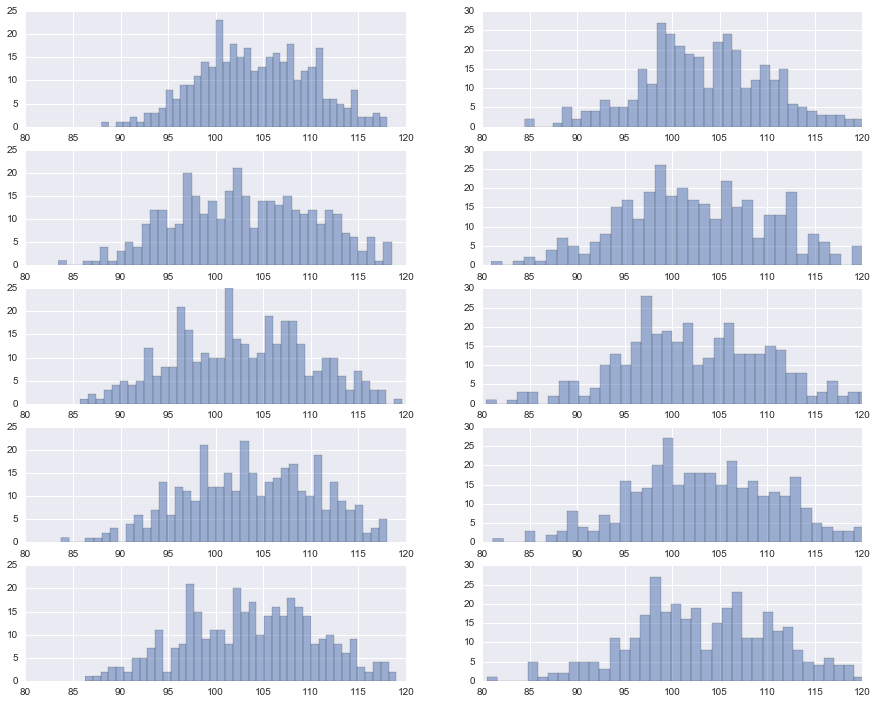

In [405]:
teams = teams.fillna(100)
fig, axs = plt.subplots(5, 2, figsize=(15, 12))
axs[0, 0].hist(teams['adjd'], bins=40, alpha=0.5)
axs[1, 0].hist(teams['drtg_log_weighted'], bins=40, alpha=0.5)
axs[2, 0].hist(teams['drtg_log'], bins=40, alpha=0.5)
axs[3, 0].hist(teams['drtg_weighted'], bins=40, alpha=0.5)
axs[4, 0].hist(teams['drtg'], bins=40, alpha=0.5)
axs[0, 1].hist(teams['adjo'], bins=40, alpha=0.5)
axs[1, 1].hist(teams['ortg_log_weighted'], bins=40, alpha=0.5)
axs[2, 1].hist(teams['ortg_log'], bins=40, alpha=0.5)
axs[3, 1].hist(teams['ortg_weighted'], bins=40, alpha=0.5)
_ = axs[4, 1].hist(teams['ortg'], bins=40, alpha=0.5)
for ax in axs.ravel():
    ax.set_xlim([80, 120])